In [1]:
%matplotlib inline

In [2]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import os
import sys
import glob
import matplotlib as mpl
import math

from PIL import Image, ImageDraw, ImageFont, ImageChops

In [3]:
sys.path.append('../../../Libraries/')

In [4]:
from Utils.Toolbox import graphics

In [5]:
rootPath = '../data/'

In [6]:
def clean_columns(data):
    data["CURRENT_FIX_Y"] = pd.to_numeric(data["CURRENT_FIX_Y"].str.replace(',','.'))
    data["CURRENT_FIX_X"] = pd.to_numeric(data["CURRENT_FIX_X"].str.replace(',','.'))
    data["NEXT_SAC_AMPLITUDE"] = pd.to_numeric(data["NEXT_SAC_AMPLITUDE"].str.replace(".", "").str.replace(",", "."))
    data["NEXT_SAC_END_X"] = pd.to_numeric(data["NEXT_SAC_END_X"].str.replace(".", "").str.replace(",", "."))
    data["NEXT_SAC_END_Y"] = pd.to_numeric(data["NEXT_SAC_END_Y"].str.replace(".", "").str.replace(",", "."))
    data["NEXT_SAC_DURATION"] = pd.to_numeric(data["NEXT_SAC_DURATION"].str.replace(".", "").str.replace(",", "."))
    data["NEXT_SAC_ANGLE"] = pd.to_numeric(data["NEXT_SAC_ANGLE"].str.replace(".", "").str.replace(",", "."))
    data["NEXT_SAC_AVG_VELOCITY"] = pd.to_numeric(data["NEXT_SAC_AVG_VELOCITY"].str.replace(".", "").str.replace(",", "."))
    data["NEXT_SAC_BLINK_DURATION"] = pd.to_numeric(data["NEXT_SAC_BLINK_DURATION"].str.replace(".", "").str.replace(",", "."))

# OVERALL

In [7]:
alld = pd.read_csv("../data/all_data.csv")
alld.shape

(49045, 25)

In [9]:
#graphics.draw_scanpath(Image.new("RGB", (1920, 1080), "gray"), scanpath)

# X&Y

### Overall look

First of all, let's look for stats of those outliers

In [11]:
def count_errors(group):
    count = group.query("CURRENT_FIX_X < 0 or CURRENT_FIX_X > 1920 or CURRENT_FIX_Y < 0 or CURRENT_FIX_Y > 1080")["EYE_USED"].count()
    group["error_ratio"] = count / group.shape[0]
    return group

# Compute the overall ratio of fixations outside the screen on the full dataset
alld = alld.groupby(["PART_ID","TRIAL_INDEX"]).apply(count_errors)

error_ratio    0.009824
dtype: float64


TRIAL_INDEX,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
error_ratio,0.004993,0.005915,0.003455,0.007743,0.004245,0.003036,0.008569,0.009944,0.007005,0.00613,0.013015,0.011532,0.006015,0.033982,0.006042,0.007666,0.026299,0.01124


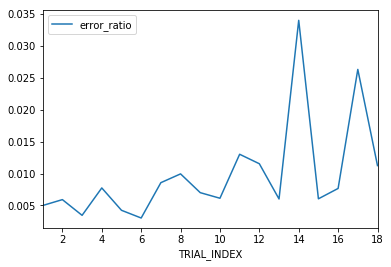

In [33]:
# Mean error rate by trial
calcul_by = "TRIAL_INDEX"
pd.DataFrame(alld.groupby(calcul_by)["error_ratio"].mean()).plot()
print(pd.DataFrame(alld.groupby(calcul_by)["error_ratio"].mean()).mean())
pd.DataFrame(alld.groupby(calcul_by)["error_ratio"].mean()).transpose()

error_ratio    0.010359
dtype: float64


PART_ID,1,2,3,4,7,8,709,710,711,712,713,714,715,716
error_ratio,0.001138,0.004105,0.003692,0.004866,0.015893,0.00219,0.007218,0.030547,0.031417,0.016603,0.009325,0.004699,0.005934,0.007395


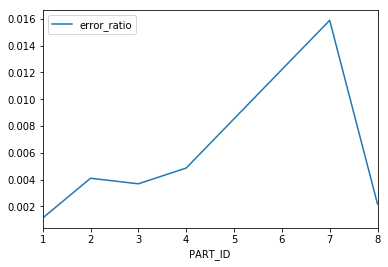

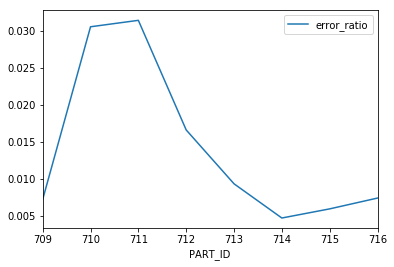

In [35]:
# Mean error rate by Participant
calcul_by = "PART_ID"
pd.DataFrame(alld.groupby(calcul_by)["error_ratio"].mean()).query("PART_ID < 700").plot()
pd.DataFrame(alld.groupby(calcul_by)["error_ratio"].mean()).query("PART_ID > 700").plot()
print(pd.DataFrame(alld.groupby(calcul_by)["error_ratio"].mean()).mean())
pd.DataFrame(alld.groupby(calcul_by)["error_ratio"].mean()).transpose()

error_ratio    0.010229
dtype: float64


CONDITION,1,2,3,4,5,6
error_ratio,0.010225,0.010116,0.007002,0.019753,0.004855,0.009421


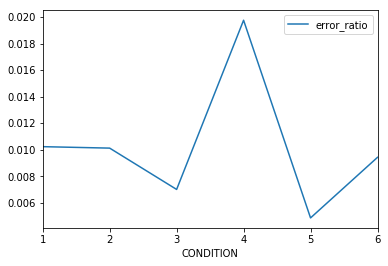

In [36]:
# Mean error rate by Condition
calcul_by = "CONDITION"
pd.DataFrame(alld.groupby(calcul_by)["error_ratio"].mean()).plot()
print(pd.DataFrame(alld.groupby(calcul_by)["error_ratio"].mean()).mean())
pd.DataFrame(alld.groupby(calcul_by)["error_ratio"].mean()).transpose()

In [126]:
alld["TASK"] = 'Target'
alld.loc[alld.query("CONDITION in [1,3,5]").index, "TASK"] = "Free"

error_ratio    0.010226
dtype: float64


TASK,Free,Target
error_ratio,0.007337,0.013114


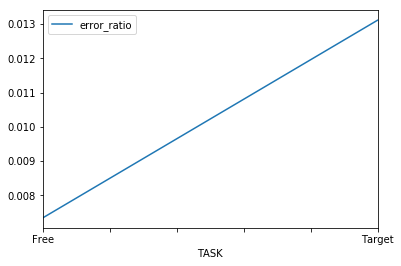

In [127]:
# Mean error rate by trial
calcul_by = "TASK"
pd.DataFrame(alld.groupby(calcul_by)["error_ratio"].mean()).plot()
print(pd.DataFrame(alld.groupby(calcul_by)["error_ratio"].mean()).mean())
pd.DataFrame(alld.groupby(calcul_by)["error_ratio"].mean()).transpose()

We can see that participants have a higher rate of error even if it is not very big. Let's look how it turns when we remove participants 710, 711 and then 7th. 

### 710 and 711

error_ratio    0.006744
dtype: float64


TRIAL_INDEX,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
error_ratio,0.005901,0.006218,0.003282,0.004745,0.002144,0.002449,0.008822,0.003488,0.008021,0.004489,0.009259,0.008721,0.005447,0.00735,0.004255,0.007902,0.024272,0.00463


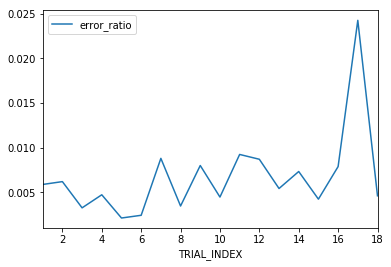

In [43]:
# Mean error rate by trial
calcul_by = "TRIAL_INDEX"
parts_to_drop = [710, 711]
pd.DataFrame(alld[~alld["PART_ID"].isin(parts_to_drop)].groupby(calcul_by)["error_ratio"].mean()).plot()
print(pd.DataFrame(alld[~alld["PART_ID"].isin(parts_to_drop)].groupby(calcul_by)["error_ratio"].mean()).mean())
pd.DataFrame(alld[~alld["PART_ID"].isin(parts_to_drop)].groupby(calcul_by)["error_ratio"].mean()).transpose()

error_ratio    0.007151
dtype: float64


CONDITION,1,2,3,4,5,6
error_ratio,0.005276,0.006678,0.005479,0.013261,0.003881,0.008332


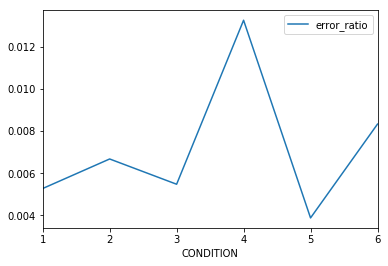

In [44]:
# Mean error rate by trial
calcul_by = "CONDITION"
parts_to_drop = [710, 711]
pd.DataFrame(alld[~alld["PART_ID"].isin(parts_to_drop)].groupby(calcul_by)["error_ratio"].mean()).plot()
print(pd.DataFrame(alld[~alld["PART_ID"].isin(parts_to_drop)].groupby(calcul_by)["error_ratio"].mean()).mean())
pd.DataFrame(alld[~alld["PART_ID"].isin(parts_to_drop)].groupby(calcul_by)["error_ratio"].mean()).transpose()

### 710, 711 and 7

error_ratio    0.005866
dtype: float64


TRIAL_INDEX,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
error_ratio,0.004758,0.006841,0.003559,0.004966,0.002358,0.002798,0.009115,0.003944,0.007592,0.003429,0.009658,0.0091,0.003511,0.007773,0.003183,0.008641,0.010619,0.003737


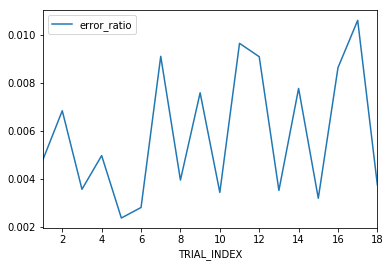

In [45]:
# Mean error rate by trial
calcul_by = "TRIAL_INDEX"
parts_to_drop = [710, 711, 7]
pd.DataFrame(alld[~alld["PART_ID"].isin(parts_to_drop)].groupby(calcul_by)["error_ratio"].mean()).plot()
print(pd.DataFrame(alld[~alld["PART_ID"].isin(parts_to_drop)].groupby(calcul_by)["error_ratio"].mean()).mean())
pd.DataFrame(alld[~alld["PART_ID"].isin(parts_to_drop)].groupby(calcul_by)["error_ratio"].mean()).transpose()

error_ratio    0.00614
dtype: float64


CONDITION,1,2,3,4,5,6
error_ratio,0.004527,0.006613,0.005603,0.007634,0.003873,0.008591


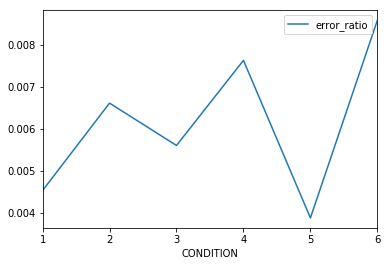

In [46]:
# Mean error rate by trial
calcul_by = "CONDITION"
parts_to_drop = [710, 711, 7]
pd.DataFrame(alld[~alld["PART_ID"].isin(parts_to_drop)].groupby(calcul_by)["error_ratio"].mean()).plot()
print(pd.DataFrame(alld[~alld["PART_ID"].isin(parts_to_drop)].groupby(calcul_by)["error_ratio"].mean()).mean())
pd.DataFrame(alld[~alld["PART_ID"].isin(parts_to_drop)].groupby(calcul_by)["error_ratio"].mean()).transpose()

## Single participant: PART_1

Participant n°1 is the one with the minimum error ration (0.002), so let's investigate the easy case before looking for more complicated cases

In [48]:
df1 = alld.query("PART_ID == 1").copy()
df1.shape

(3516, 26)

In [50]:
# Number of looks on the LEFT of the screen
df1.query("CURRENT_FIX_X < 0")["EYE_USED"].count()

0

No look on the left of the screen

In [51]:
# Number of looks on the RIGHT of the screen
df1.query("CURRENT_FIX_X > 1920")["EYE_USED"].count()

2

In [52]:
# Number of looks on the LEFT of the screen
df1.query("CURRENT_FIX_Y < 0")["EYE_USED"].count()

0

In [53]:
# Number of looks on the LEFT of the screen
df1.query("CURRENT_FIX_Y > 1080")["EYE_USED"].count()

2

Are these related to a blink ?

**RIGHT**

In [56]:
# Count of blinks during the saccade
df1.query("CURRENT_FIX_X > 1920").query("NEXT_SAC_CONTAINS_BLINK == 'true'")["EYE_USED"].count()

0

In [59]:
df1.query("CURRENT_FIX_X > 1920")

,TRIAL_INDEX,EYE_USED,CURRENT_FIX_X,CURRENT_FIX_Y,CURRENT_FIX_START,CURRENT_FIX_DURATION,CURRENT_FIX_BLINK_AROUND,NEXT_SAC_END_X,NEXT_SAC_END_Y,NEXT_SAC_AMPLITUDE,...,NEXT_SAC_BLINK_DURATION,CUMSUM_BLINK_DURATION,PART_ID,DATETIME,OFFSET,Y_OFFSET,WEBSITE_ID,CONDITION,CALIBRATION_PROBLEM,error_ratio
37585,3,RIGHT,1930.8,281.8,32472.0,113,NONE,1884.6,580.7,7.52,...,0.0,1107.0,1,2018-04-03 14:56:30.467,7114,7395.8,3,2,No,0.006173
37590,3,RIGHT,1938.6,94.7,34861.0,439,NONE,1579.7,12.9,8.59,...,0.0,1107.0,1,2018-04-03 14:56:32.856,5427,5521.7,3,2,No,0.006173


In [70]:
# Is there a blink around ?
df1.ix[37580:37595]

,TRIAL_INDEX,EYE_USED,CURRENT_FIX_X,CURRENT_FIX_Y,CURRENT_FIX_START,CURRENT_FIX_DURATION,CURRENT_FIX_BLINK_AROUND,NEXT_SAC_END_X,NEXT_SAC_END_Y,NEXT_SAC_AMPLITUDE,...,NEXT_SAC_BLINK_DURATION,CUMSUM_BLINK_DURATION,PART_ID,DATETIME,OFFSET,Y_OFFSET,WEBSITE_ID,CONDITION,CALIBRATION_PROBLEM,error_ratio
37580,3,RIGHT,658.9,305.8,31332.0,146,NONE,551.2,328.8,2.99,...,0.0,1107.0,1,2018-04-03 14:56:29.327,7769,8074.8,3,2,No,0.006173
37581,3,RIGHT,547.7,340.3,31504.0,221,NONE,762.5,235.8,7.01,...,0.0,1107.0,1,2018-04-03 14:56:29.499,7727,8067.3,3,2,No,0.006173
37582,3,RIGHT,764.2,286.2,31759.0,330,NONE,1063.3,53.9,11.38,...,0.0,1107.0,1,2018-04-03 14:56:29.754,7709,7995.2,3,2,No,0.006173
37583,3,RIGHT,1061.9,61.2,32142.0,100,NONE,1573.9,139.3,13.91,...,0.0,1107.0,1,2018-04-03 14:56:30.137,7140,7201.2,3,2,No,0.006173
37584,3,RIGHT,1569.5,148.2,32294.0,130,NONE,1938.8,286.8,9.70,...,0.0,1107.0,1,2018-04-03 14:56:30.289,7127,7275.2,3,2,No,0.006173
37585,3,RIGHT,1930.8,281.8,32472.0,113,NONE,1884.6,580.7,7.52,...,0.0,1107.0,1,2018-04-03 14:56:30.467,7114,7395.8,3,2,No,0.006173
37586,3,RIGHT,1881.5,573.5,32646.0,224,NONE,1898.9,638.7,1.78,...,0.0,1107.0,1,2018-04-03 14:56:30.641,6718,7291.5,3,2,No,0.006173
37587,3,RIGHT,1897.3,626.9,32893.0,372,NONE,1911.4,668.1,0.97,...,0.0,1107.0,1,2018-04-03 14:56:30.888,6527,7153.9,3,2,No,0.006173
37588,3,RIGHT,1911.7,671.4,33288.0,1115,NONE,1928.6,209.6,11.50,...,0.0,1107.0,1,2018-04-03 14:56:31.283,6502,7173.4,3,2,No,0.006173
37589,3,RIGHT,1913.9,194.8,34461.0,373,NONE,1955.7,92.9,2.62,...,0.0,1107.0,1,2018-04-03 14:56:32.456,5427,5621.8,3,2,No,0.006173


No blink around, so let's check how far the participant looked

-- RIGHT -- 
Mean distance outside the screen is 14.7px (0.42°)
Mean start time is 33.67s


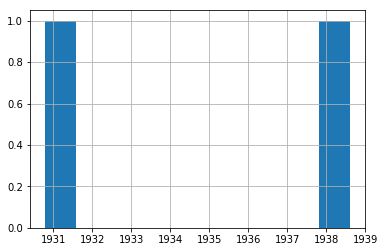

In [79]:
d = (df1.query("CURRENT_FIX_X > 1920")["CURRENT_FIX_X"] - 1920).mean()
s = df1.query("CURRENT_FIX_X > 1920")["CURRENT_FIX_START"].mean()
print("-- RIGHT -- ")
print("Mean distance outside the screen is {}px ({}°)".format(round(d, 2), round(d/35, 2)))
print("Mean start time is {}s".format(round(s/1000, 2)))
df1.query("CURRENT_FIX_X > 1920")["CURRENT_FIX_X"].hist()

In [81]:
# Degree error of each error
(df1.query("CURRENT_FIX_X > 1920")["CURRENT_FIX_X"] - 1920)/35

37585    0.308571
37590    0.531429
Name: CURRENT_FIX_X, dtype: float64

**Since the fovea is 2-3° we can consider this type of outlier (<1°) can be edited to max value of X (1920).**

**DOWN**

In [83]:
# Count of blinks during the saccade
df1.query("CURRENT_FIX_Y > 1080").query("NEXT_SAC_CONTAINS_BLINK == 'true'")["EYE_USED"].count()

2

In [84]:
df1.query("CURRENT_FIX_Y > 1080")

,TRIAL_INDEX,EYE_USED,CURRENT_FIX_X,CURRENT_FIX_Y,CURRENT_FIX_START,CURRENT_FIX_DURATION,CURRENT_FIX_BLINK_AROUND,NEXT_SAC_END_X,NEXT_SAC_END_Y,NEXT_SAC_AMPLITUDE,...,NEXT_SAC_BLINK_DURATION,CUMSUM_BLINK_DURATION,PART_ID,DATETIME,OFFSET,Y_OFFSET,WEBSITE_ID,CONDITION,CALIBRATION_PROBLEM,error_ratio
39368,11,RIGHT,520.1,1349.9,27394.0,72,AFTER,911.9,561.9,25.143689,...,544.0,1326.0,1,2018-04-03 15:11:36.388,14,1363.9,12,4,No,0.009524
40113,16,RIGHT,202.6,2003.1,54298.0,215,BOTH,600.0,481.3,44.938071,...,369.0,2630.0,1,2018-04-03 15:18:22.292,858,2861.1,17,4,No,0.004695


The second fixation contains blinks in both rows after and before so let's investigate on this one first

In [86]:
df1.ix[40110:40115]

,TRIAL_INDEX,EYE_USED,CURRENT_FIX_X,CURRENT_FIX_Y,CURRENT_FIX_START,CURRENT_FIX_DURATION,CURRENT_FIX_BLINK_AROUND,NEXT_SAC_END_X,NEXT_SAC_END_Y,NEXT_SAC_AMPLITUDE,...,NEXT_SAC_BLINK_DURATION,CUMSUM_BLINK_DURATION,PART_ID,DATETIME,OFFSET,Y_OFFSET,WEBSITE_ID,CONDITION,CALIBRATION_PROBLEM,error_ratio
40110,16,RIGHT,1245.4,266.3,53225.0,187,NONE,1240.2,136.3,3.630000,...,0.0,2112.0,1,2018-04-03 15:18:21.219,916,1182.3,17,4,No,0.004695
40111,16,RIGHT,1246.3,147.0,53443.0,269,NONE,440.2,290.2,22.230000,...,0.0,2112.0,1,2018-04-03 15:18:21.437,858,1005.0,17,4,No,0.004695
40112,16,RIGHT,409.5,371.0,53641.0,685,AFTER,206.7,2032.4,47.820906,...,149.0,2261.0,1,2018-04-03 15:18:21.635,858,1229.0,17,4,No,0.004695
40113,16,RIGHT,202.6,2003.1,54298.0,215,BOTH,600.0,481.3,44.938071,...,369.0,2630.0,1,2018-04-03 15:18:22.292,858,2861.1,17,4,No,0.004695
40114,16,RIGHT,584.6,470.3,54946.0,237,BEFORE,540.0,416.3,2.000000,...,0.0,2630.0,1,2018-04-03 15:18:22.940,858,1328.3,17,4,No,0.004695
40115,16,RIGHT,536.4,427.5,55207.0,180,NONE,480.1,434.0,1.360000,...,0.0,2630.0,1,2018-04-03 15:18:23.201,858,1285.5,17,4,No,0.004695


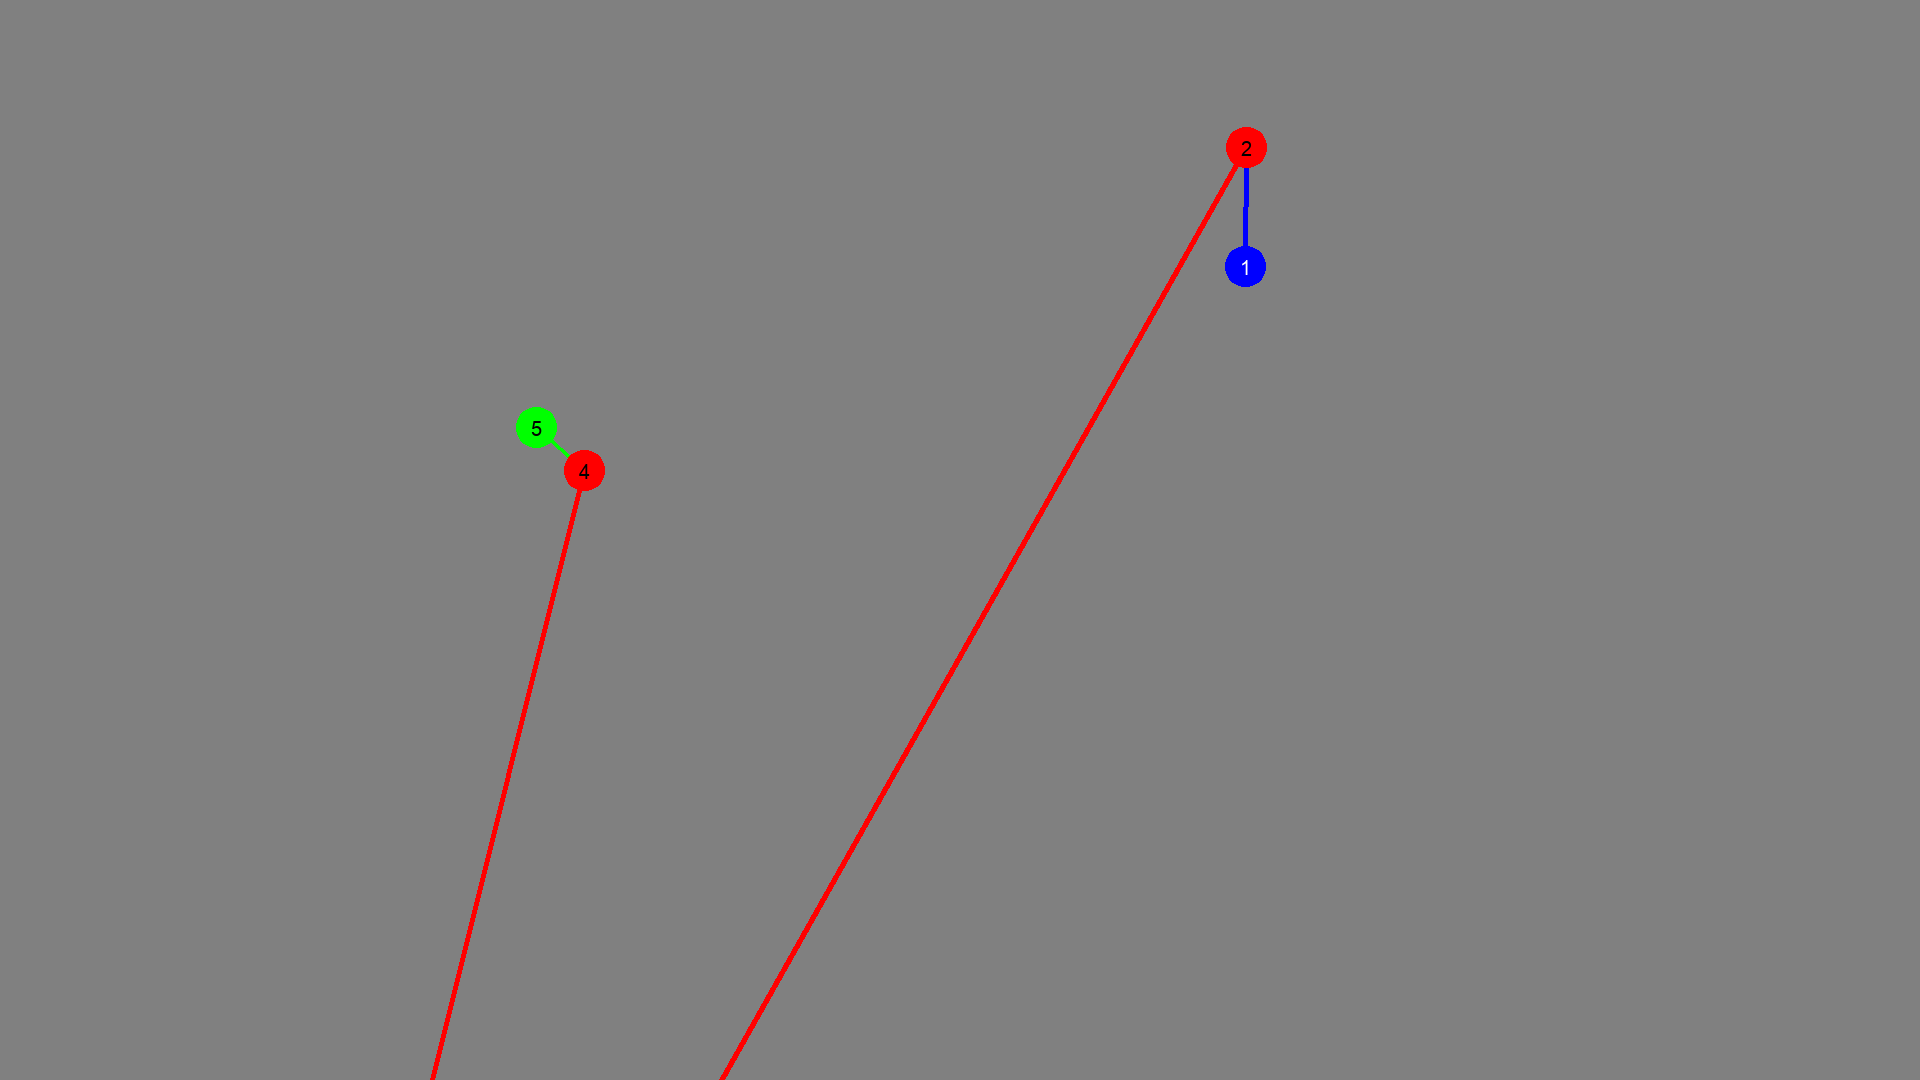

In [88]:
graphics.draw_scanpath(Image.new("RGB", (1920, 1080), "gray"), [
    [1245, 266],
    [1246, 147],
    [202, 2003],
    [584, 470],
    [536, 427],
])

This problem looks more like a blink issue than fixation outside the screen

In [89]:
df1.ix[39366:39370]

,TRIAL_INDEX,EYE_USED,CURRENT_FIX_X,CURRENT_FIX_Y,CURRENT_FIX_START,CURRENT_FIX_DURATION,CURRENT_FIX_BLINK_AROUND,NEXT_SAC_END_X,NEXT_SAC_END_Y,NEXT_SAC_AMPLITUDE,...,NEXT_SAC_BLINK_DURATION,CUMSUM_BLINK_DURATION,PART_ID,DATETIME,OFFSET,Y_OFFSET,WEBSITE_ID,CONDITION,CALIBRATION_PROBLEM,error_ratio
39366,11,RIGHT,712.2,555.0,27112.0,249,BEFORE,610.1,290.4,7.560000,...,0.0,782.0,1,2018-04-03 15:11:36.106,15,570.0,12,4,No,0.009524
39367,11,RIGHT,615.5,299.8,27427.0,372,NONE,511.7,1360.4,26.660000,...,0.0,782.0,1,2018-04-03 15:11:36.421,13,312.8,12,4,No,0.009524
39368,11,RIGHT,520.1,1349.9,27394.0,72,AFTER,911.9,561.9,25.143689,...,544.0,1326.0,1,2018-04-03 15:11:36.388,14,1363.9,12,4,No,0.009524
39369,11,RIGHT,898.1,556.2,28210.0,299,BEFORE,870.1,458.1,2.550000,...,0.0,1326.0,1,2018-04-03 15:11:37.204,0,556.2,12,4,No,0.009524
39370,12,RIGHT,1590.1,86.1,8.0,261,NONE,1074.0,378.3,15.940000,...,0.0,0.0,1,2018-04-03 15:12:17.002,0,86.1,6,6,No,0.000000


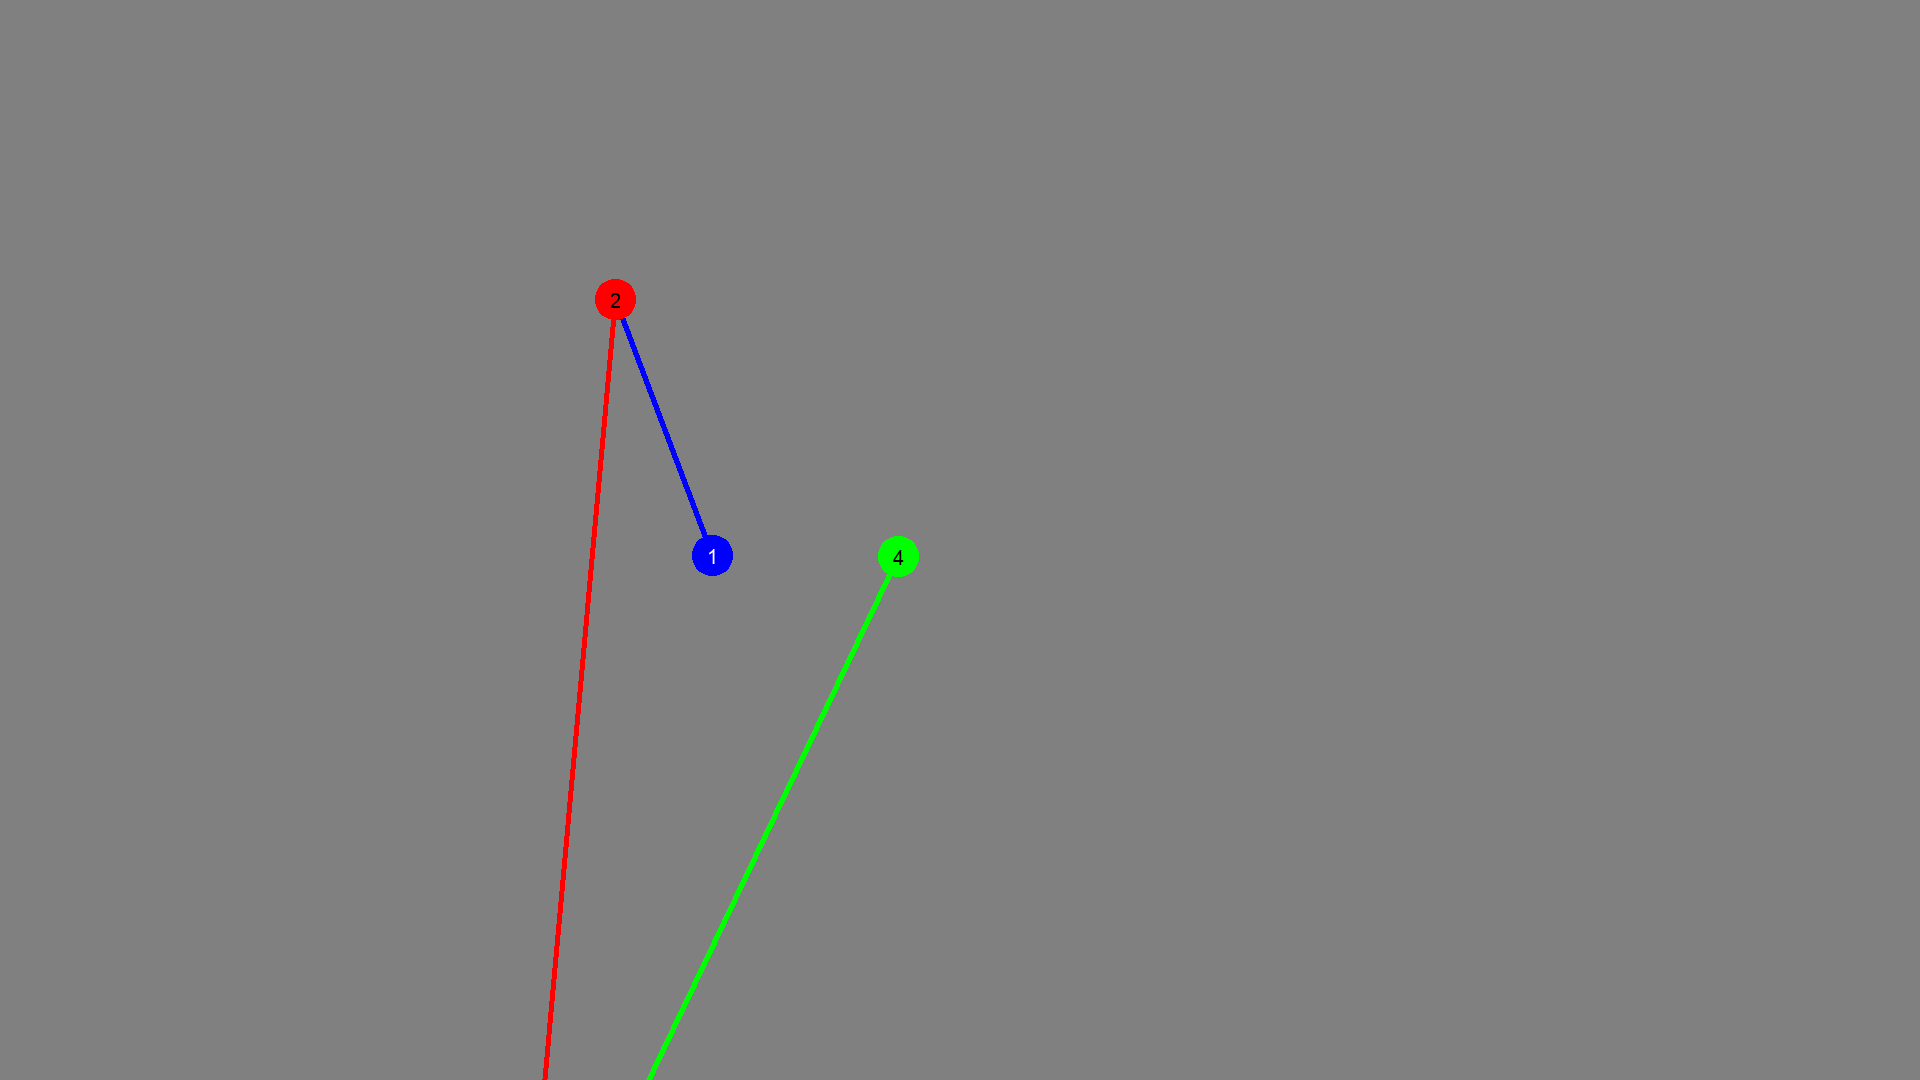

In [91]:
graphics.draw_scanpath(Image.new("RGB", (1920, 1080), "gray"), [
    [712, 555],
    [615, 299],
    [520, 1349],
    [898, 556]
])

Here we have a blink AND the end of the trial, which means the participant tends to look down to press the space bar to end the trial. So this outsider is a blink matter too.

## Single participant: PART_710

In [93]:
df710 = alld.query("PART_ID == 710").copy()
df710.shape

(2979, 26)

In [94]:
# Number of looks on the LEFT of the screen
df1.query("CURRENT_FIX_X < 0")["EYE_USED"].count()

19

In [95]:
# Number of looks on the RIGHT of the screen
df1.query("CURRENT_FIX_X > 1920")["EYE_USED"].count()

0

In [96]:
# Number of looks on the TOP of the screen
df1.query("CURRENT_FIX_Y < 0")["EYE_USED"].count()

87

In [97]:
# Number of looks on the BOTTOM of the screen
df1.query("CURRENT_FIX_Y > 1080")["EYE_USED"].count()

2

**DOWN**

This situation looks similar to previous participant. Let's see the condition to know if this is related to space bar

In [98]:
df1.query("CURRENT_FIX_Y > 1080")["CONDITION"].unique()

array([2])

These are TF tasks. Let's see if it is at the end of the trial

In [99]:
df1.query("CURRENT_FIX_Y > 1080")

,TRIAL_INDEX,EYE_USED,CURRENT_FIX_X,CURRENT_FIX_Y,CURRENT_FIX_START,CURRENT_FIX_DURATION,CURRENT_FIX_BLINK_AROUND,NEXT_SAC_END_X,NEXT_SAC_END_Y,NEXT_SAC_AMPLITUDE,...,NEXT_SAC_BLINK_DURATION,CUMSUM_BLINK_DURATION,PART_ID,DATETIME,OFFSET,Y_OFFSET,WEBSITE_ID,CONDITION,CALIBRATION_PROBLEM,error_ratio
27990,5,RIGHT,857.4,1564.5,68775.0,44,BOTH,787.5,1490.1,2.916717,...,28.0,280.0,710,2018-03-20 13:59:15.768,258,1822.5,17,2,Yes,0.018519
27991,5,RIGHT,854.2,1563.4,68706.0,29,BOTH,529.6,409.5,34.248198,...,160.0,440.0,710,2018-03-20 13:59:15.699,258,1821.4,17,2,Yes,0.018519


In [100]:
df1.ix[27989:27995]

,TRIAL_INDEX,EYE_USED,CURRENT_FIX_X,CURRENT_FIX_Y,CURRENT_FIX_START,CURRENT_FIX_DURATION,CURRENT_FIX_BLINK_AROUND,NEXT_SAC_END_X,NEXT_SAC_END_Y,NEXT_SAC_AMPLITUDE,...,NEXT_SAC_BLINK_DURATION,CUMSUM_BLINK_DURATION,PART_ID,DATETIME,OFFSET,Y_OFFSET,WEBSITE_ID,CONDITION,CALIBRATION_PROBLEM,error_ratio
27989,5,RIGHT,407.8,567.3,68399.0,127,AFTER,787.5,1490.1,28.510391,...,130.0,252.0,710,2018-03-20 13:59:15.392,258,825.3,17,2,Yes,0.018519
27990,5,RIGHT,857.4,1564.5,68775.0,44,BOTH,787.5,1490.1,2.916717,...,28.0,280.0,710,2018-03-20 13:59:15.768,258,1822.5,17,2,Yes,0.018519
27991,5,RIGHT,854.2,1563.4,68706.0,29,BOTH,529.6,409.5,34.248198,...,160.0,440.0,710,2018-03-20 13:59:15.699,258,1821.4,17,2,Yes,0.018519
27992,5,RIGHT,525.9,404.4,68964.0,209,BEFORE,NaN,NaN,NaN,...,0.0,440.0,710,2018-03-20 13:59:15.957,171,575.4,17,2,Yes,0.018519
27993,6,RIGHT,763.8,602.0,421.0,314,NONE,697.1,619.9,2.060000,...,0.0,0.0,710,2018-03-20 13:59:53.414,0,602.0,3,2,No,0.007576
27994,6,RIGHT,687.2,619.7,693.0,138,AFTER,797.0,684.2,3.638377,...,86.0,86.0,710,2018-03-20 13:59:53.686,0,619.7,3,2,No,0.007576
27995,6,RIGHT,789.9,633.7,898.0,70,BOTH,1346.9,957.5,18.407972,...,90.0,176.0,710,2018-03-20 13:59:53.891,0,633.7,3,2,No,0.007576


Conclusion: End of a TF trial AND blinks in both directions !

**UP**

In [102]:
# Number of looks on the TOP of the screen
df710.query("CURRENT_FIX_Y < 0")["EYE_USED"].count()

87

In [111]:
# Number of looks on the TOP of the screen
df710.query("CURRENT_FIX_Y < 0")["CONDITION"].value_counts()

4    44
2    14
3    11
5     8
6     6
1     4
Name: CONDITION, dtype: int64

In [114]:
# Percentage of TF tasks
(44+14+6)*100/87

73.5632183908046

In [133]:
# Number of looks on the TOP of the screen
df1.query("CURRENT_FIX_Y < 0 and CURRENT_FIX_DURATION <= 120")["EYE_USED"].count()

35

-- UP -- 
On 87, 11(13.0%) where blinks
Mean distance is -138.0 (-4.0°)
Mean start time is 13.0s


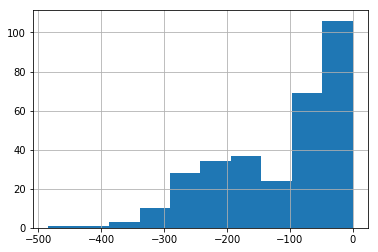

In [104]:
t = df710.query("CURRENT_FIX_Y < 0")["CURRENT_FIX_Y"].count()
c = df710.query("CURRENT_FIX_Y < 0").query("NEXT_SAC_CONTAINS_BLINK == 'true'")["CURRENT_FIX_Y"].count()
d = df710.query("CURRENT_FIX_Y < 0")["CURRENT_FIX_Y"].mean()
s = df710.query("CURRENT_FIX_Y < 0")["CURRENT_FIX_START"].mean()
print("-- UP -- ")
print("On {}, {}({}%) where blinks".format(t, c, round(c/t*100, 0)))
print("Mean distance is {} ({}°)".format(round(d, 0), round(d/35, 0)))
print("Mean start time is {}s".format(round(s/1000, 0)))
alld.query("CURRENT_FIX_Y < 0")["CURRENT_FIX_Y"].hist()

In [146]:
alld.query("CURRENT_FIX_DURATION < 120 and CURRENT_FIX_BLINK_AROUND == 'NONE'")["TRIAL_INDEX"].count()

3704

In [147]:
alld.query("CURRENT_FIX_DURATION < 120 and CURRENT_FIX_BLINK_AROUND != 'NONE'")["TRIAL_INDEX"].count()

1252

-- LEFT -- 
On 79, 12(15.0%) where blinks
Mean distance is -102.0 (-3.0°)
Mean start time is 14.0s


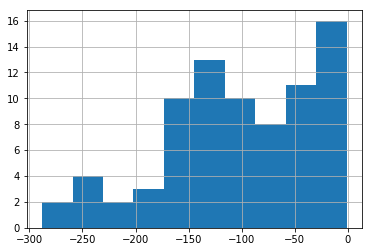

In [86]:
t = alld.query("CURRENT_FIX_X < 0")["EYE_USED"].count()
c = alld.query("CURRENT_FIX_X < 0").query("NEXT_SAC_CONTAINS_BLINK == 'true'")["EYE_USED"].count()
d = alld.query("CURRENT_FIX_X < 0")["CURRENT_FIX_X"].mean()
s = alld.query("CURRENT_FIX_X < 0")["CURRENT_FIX_START"].mean()
print("-- LEFT -- ")
print("On {}, {}({}%) where blinks".format(t, c, round(c/t*100, 0)))
print("Mean distance is {} ({}°)".format(round(d, 0), round(d/35, 0)))
print("Mean start time is {}s".format(round(s/1000, 0)))
alld.query("CURRENT_FIX_X < 0")["CURRENT_FIX_X"].hist()

-- RIGHT -- 
On 49, 8(16.0%) where blinks
Mean distance is 90.0 (3.0°)
Mean start time is 37.0s


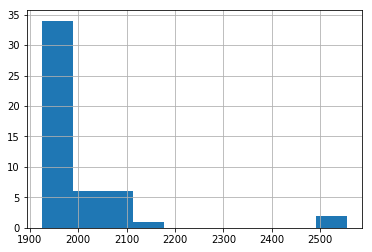

In [100]:
t = alld.query("CURRENT_FIX_X > 1920")["CURRENT_FIX_X"].count()
c = alld.query("CURRENT_FIX_X > 1920").query("NEXT_SAC_CONTAINS_BLINK == 'true'")["CURRENT_FIX_X"].count()
d = (alld.query("CURRENT_FIX_X > 1920")["CURRENT_FIX_X"] - 1920).mean()
s = alld.query("CURRENT_FIX_X > 1920")["CURRENT_FIX_START"].mean()
print("-- RIGHT -- ")
print("On {}, {}({}%) where blinks".format(t, c, round(c/t*100, 0)))
print("Mean distance is {} ({}°)".format(round(d, 0), round(d/35, 0)))
print("Mean start time is {}s".format(round(s/1000, 0)))
alld.query("CURRENT_FIX_X > 1920")["CURRENT_FIX_X"].hist()

-- UP -- 
On 282, 41(15.0%) where blinks
Mean distance is -113.0 (-3.0°)
Mean start time is 19.0s


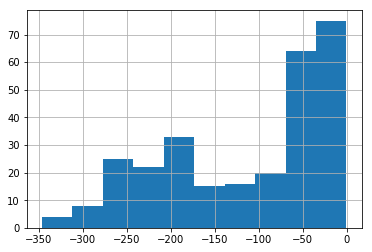

In [88]:
t = alld.query("CURRENT_FIX_Y < 0")["CURRENT_FIX_Y"].count()
c = alld.query("CURRENT_FIX_Y < 0").query("NEXT_SAC_CONTAINS_BLINK == 'true'")["CURRENT_FIX_Y"].count()
d = alld.query("CURRENT_FIX_Y < 0")["CURRENT_FIX_Y"].mean()
s = alld.query("CURRENT_FIX_Y < 0")["CURRENT_FIX_START"].mean()
print("-- UP -- ")
print("On {}, {}({}%) where blinks".format(t, c, round(c/t*100, 0)))
print("Mean distance is {} ({}°)".format(round(d, 0), round(d/35, 0)))
print("Mean start time is {}s".format(round(s/1000, 0)))
alld.query("CURRENT_FIX_Y < 0")["CURRENT_FIX_Y"].hist()

-- DOWN -- 
On 42, 13(31.0%) where blinks
Mean distance is 169.0 (5.0°)
Mean start time is 42.0s


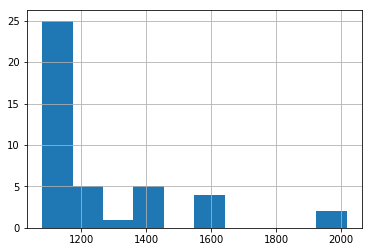

In [98]:
t = alld.query("CURRENT_FIX_Y > 1080")["CURRENT_FIX_Y"].count()
c = alld.query("CURRENT_FIX_Y > 1080").query("NEXT_SAC_CONTAINS_BLINK == 'true'")["CURRENT_FIX_Y"].count()
d = (alld.query("CURRENT_FIX_Y > 1080")["CURRENT_FIX_Y"] - 1080).mean()
s = alld.query("CURRENT_FIX_Y > 1080")["CURRENT_FIX_START"].mean()
print("-- DOWN -- ")
print("On {}, {}({}%) where blinks".format(t, c, round(c/t*100, 0)))
print("Mean distance is {} ({}°)".format(round(d, 0), round(d/35, 0)))
print("Mean start time is {}s".format(round(s/1000, 0)))
alld.query("CURRENT_FIX_Y > 1080")["CURRENT_FIX_Y"].hist()

In [27]:
alld.query("CURRENT_FIX_Y > 1080").groupby("CONDITION")["CURRENT_FIX_Y"].count()

CONDITION
2     5
4    15
5     4
6    18
Name: CURRENT_FIX_Y, dtype: int64

In [28]:
alld.query("CURRENT_FIX_Y < 0").groupby("CONDITION")["CURRENT_FIX_Y"].count()

CONDITION
1    65
2    45
3    39
4    77
5    23
6    33
Name: CURRENT_FIX_Y, dtype: int64

In [29]:
alld.query("CURRENT_FIX_X < 0").groupby("CONDITION")["CURRENT_FIX_X"].count()

CONDITION
1    27
2     2
3    11
4    14
5     6
6    19
Name: CURRENT_FIX_X, dtype: int64

In [30]:
alld.query("CURRENT_FIX_X > 1920").groupby("CONDITION")["CURRENT_FIX_X"].count()

CONDITION
1     6
2     3
3    17
4     5
5     9
6     9
Name: CURRENT_FIX_X, dtype: int64

In [35]:
alld.groupby("CONDITION")["CURRENT_FIX_START"].mean()

CONDITION
1    28367.346094
2    28312.133736
3    28956.823996
4    27689.579189
5    28567.750804
6    26867.042294
Name: CURRENT_FIX_START, dtype: float64

In [36]:
(2000-1920)/35

2.2857142857142856

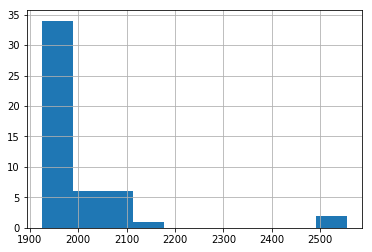

In [38]:
alld.query("CURRENT_FIX_X > 1920")["CURRENT_FIX_X"].hist()

In [90]:
print("Out of the zone:")
alld.query("CURRENT_FIX_X < 0 and CURRENT_FIX_X < -180")["EYE_USED"].count()

Out of the zone:


9

In [91]:
print("In the zone:")
alld.query("CURRENT_FIX_X < 0 and CURRENT_FIX_X > -180")["EYE_USED"].count()

In the zone:


70

In [41]:
print("In the zone:")
alld.query("CURRENT_FIX_X > 1920 and CURRENT_FIX_X < 2095")["EYE_USED"].count()

In the zone:


43

In [42]:
print("Out of the zone:")
alld.query("CURRENT_FIX_X > 1920 and CURRENT_FIX_X > 2095")["EYE_USED"].count()

Out of the zone:


6

In [43]:
print("In the zone:")
alld.query("CURRENT_FIX_Y > 1080 and CURRENT_FIX_Y < 1255")["EYE_USED"].count()

In the zone:


29

In [44]:
print("Out of the zone:")
alld.query("CURRENT_FIX_Y > 1080 and CURRENT_FIX_Y > 1255")["EYE_USED"].count()

Out of the zone:


13

In [45]:
print("Out of the zone:")
alld.query("CURRENT_FIX_Y < 0 and CURRENT_FIX_Y < -180")["EYE_USED"].count()

Out of the zone:


84

In [46]:
print("In the zone:")
alld.query("CURRENT_FIX_Y < 0 and CURRENT_FIX_Y > -180")["EYE_USED"].count()

In the zone:


198

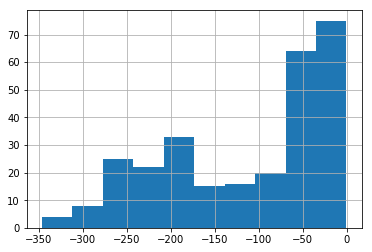

In [47]:
alld.query("CURRENT_FIX_Y < 0")["CURRENT_FIX_Y"].hist()

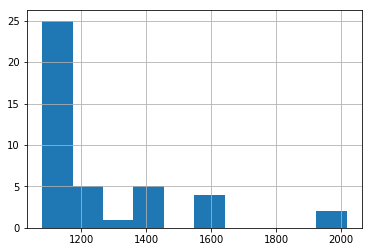

In [48]:
alld.query("CURRENT_FIX_Y > 1080")["CURRENT_FIX_Y"].hist()

In [49]:
5*35

175

In [50]:
alld.query("CURRENT_FIX_X < 0 and CURRENT_FIX_X > -180").groupby("TRIAL_INDEX")["EYE_USED"].count()

TRIAL_INDEX
2      1
4      4
5      1
6      5
7      3
9      6
11    10
12     7
14    21
17    12
Name: EYE_USED, dtype: int64

In [51]:
alld.query("CURRENT_FIX_Y < 0 and CURRENT_FIX_Y > -180").groupby("TRIAL_INDEX")["EYE_USED"].count()

TRIAL_INDEX
1      2
2     14
3      7
4     14
5      5
7      6
8     18
9      3
10     9
11    16
12     8
13     4
14    41
16    15
17    20
18    16
Name: EYE_USED, dtype: int64